In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import os
import cv2
import albumentations as A
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torch
import torchvision.transforms as T
from torchvision.transforms import v2
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torchvision.models import vgg16, VGG16_Weights
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import pandas as pd
from torch.optim.lr_scheduler import CyclicLR


2024-12-03 18:33:22.523463: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 18:33:22.536247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 18:33:22.546996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 18:33:22.550094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 18:33:22.558041: I tensorflow/core/platform/cpu_feature_guar

In [3]:
df=pd.read_csv('./fingerprint_data')
print(df.shape)
df_0=df[df['gender']==0].reset_index(drop=True)
df_1=df[df['gender']==1].reset_index(drop=True)
df['id']=df['id']-1
print(len(df_0),len(df_1))
df
df=df[~df['finger'].between(0,3)].reset_index(drop=True)
df

(55265, 9)
44198 11067


,Unnamed: 0.1,Unnamed: 0,file_path,modification,gender,hand,finger,method,id
0,6,6,./archive/SOCOFing/Real/1__M_Right_little_fing...,0,0,0,4,0,0
1,8,8,./archive/SOCOFing/Real/1__M_Left_little_finge...,0,0,1,4,0,0
2,12,12,./archive/SOCOFing/Altered/Altered-Easy/1__M_L...,1,0,1,4,3,0
3,18,18,./archive/SOCOFing/Altered/Altered-Easy/1__M_R...,1,0,0,4,3,0
4,19,19,./archive/SOCOFing/Altered/Altered-Easy/1__M_L...,1,0,1,4,1,0
...,...,...,...,...,...,...,...,...,...
10925,55240,55240,./archive/SOCOFing/Altered/Altered-Medium/600_...,2,0,1,4,3,599
10926,55242,55242,./archive/SOCOFing/Altered/Altered-Medium/600_...,2,0,0,4,1,599
10927,55249,55249,./archive/SOCOFing/Altered/Altered-Hard/600__M...,3,0,1,4,2,599
10928,55261,55261,./archive/SOCOFing/Altered/Altered-Hard/600__M...,3,0,0,4,2,599


In [3]:
train, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Second split: Validation (15%) and Test (15%) from Temp (30%)
val, test = train_test_split(temp_df, test_size=0.5, random_state=42)


In [4]:
train=df[df['id']<400]
val=df[df['id'].between(400,500)]
test=df[df['id']>500]

In [5]:
len(test)

1815

In [8]:
class train_dataloader(torch.utils.data.Dataset):
    def __init__(self, frame):
        self.frame=frame
        self.front_path = [f for f in frame['file_path'].tolist()]
        self.pred = [a for a in frame['gender'].tolist()]

    def __getitem__(self, index):
        img_conv=img_trf_train(str(self.front_path[index]))
        image, target = img_conv, int(self.pred[index])
        return image, target

    def __len__(self):
        return len(self.frame)

class val_dataloader(torch.utils.data.Dataset):
    def __init__(self, frame):
        self.frame=frame
        self.front_path = [f for f in frame['file_path'].tolist()]
        self.pred = [a for a in frame['gender'].tolist()]

    def __getitem__(self, index):
        img_conv=img_trf_val(str(self.front_path[index]))
        image, target = img_conv, int(self.pred[index])
        return image, target

    def __len__(self):
        return len(self.frame)


In [9]:
def img_trf_train(code):
    try:
        img=cv2.imread(str(code))#
        #add transform
        transform=A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.6,1.6), shear=(-5,5), rotate=(-180,180), p=0.7,fit_output=False,keep_ratio=True),
        A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, p=0.2),
        A.GridDistortion (num_steps=5, distort_limit=(-0.3, 0.3), interpolation=1, border_mode=2, p=0.2),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(224,224),
        ToTensorV2()])
        front_transformed=transform(image=img)["image"]
        return front_transformed 
        
    except:
        z=torch.zeros(3,224,224)
    return z

def img_trf_val(code):
    try:
        img=cv2.imread(str(code))
        #add transform
        transform=A.Compose([
        A.Resize(224,224),
        ToTensorV2()])
        front_transformed=transform(image=img)["image"]
        return front_transformed 
        
    except:
        z=torch.zeros(3,224,224)
    return z

In [10]:
train_dataset = train_dataloader(train)
val_dataset=val_dataloader(val)
test_dataset = val_dataloader(test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader= DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
#early stoping
class EarlyStopping:
        def __init__(self, tolerance=5, min_delta=3):
    
            self.tolerance = tolerance
            self.min_delta = min_delta
            self.counter = 0
            self.early_stop = False
            self.min_validation_loss = float('inf')

    
        def __call__(self, train_loss, validation_loss):
            print(self.counter)
            if validation_loss < self.min_validation_loss: 
                self.min_validation_loss = validation_loss
                self.counter = 0
            elif validation_loss > (self.min_validation_loss + self.min_delta/3) or (validation_loss - train_loss) > self.min_delta:
                self.counter += 1
                if self.counter >= self.tolerance:  
                    self.early_stop = True
        
    


In [12]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
import time
import copy
import gc

num_epochs = 50

def train_model():
    early_stopping = EarlyStopping(tolerance=10, min_delta=0.1)

    since = time.time()
    best_error = 100
    best_acc=0
    train_loss = []
    val_loss = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0
        running_corrects = 0
        total_train_samples = 0

        for images, masks in train_dataloader:
            images = images.to(device=device, dtype=torch.float)
            masks = masks.to(device=device, dtype=torch.long) 
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predictions
            
            loss = loss_function(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_corrects += (preds == masks).sum().item()  # Sum up correct predictions
            total_train_samples += masks.size(0)  # Count total samples in the batch

            train_loss.append(loss.item())

        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_train_acc = running_corrects / total_train_samples
        train_acc_history.append(epoch_train_acc)

        # Validation phase
        model.eval()
        validation_loss = 0
        validation_corrects = 0
        total_val_samples = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device=device, dtype=torch.float)
                labels = labels.to(device=device, dtype=torch.long) 

                output_val = model(images)
                val_loss_batch = loss_function(output_val, labels)
                validation_loss += val_loss_batch.item()

                _, val_preds = torch.max(output_val, 1)  # Get validation predictions
                validation_corrects += (val_preds == labels).sum().item()  # Sum up correct predictions
                total_val_samples += labels.size(0)  # Count total samples in the batch

        epoch_val_loss = validation_loss / len(val_dataloader)
        epoch_val_acc = validation_corrects / total_val_samples
        val_acc_history.append(epoch_val_acc)
        #scheduler.step()
        #lr=optimizer.param_groups[0]["lr"]
        # Save best model based on validation loss
        if epoch_val_acc >= best_acc:
            best_acc=epoch_val_acc
            #best_error = epoch_val_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, './gender_predict_final_2_finger.pt')
            print(f"Best Model Saved - Validation Accuracy: {best_acc} at Epoch: {best_epoch+1}")
            
        early_stopping(loss.item(), validation_loss)
        if early_stopping.early_stop:
            print("We are early stopped at epoch:", epoch)
            break
        # Print epoch metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {epoch_train_loss:.4f}, "
              f"Training Accuracy: {epoch_train_acc * 100:.2f}%, "
              f"Validation Loss: {epoch_val_loss:.4f}, "
              f"Validation Accuracy: {epoch_val_acc * 100:.2f}%")

        # Clean up
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()

    time_elapsed = time.time() - since
    print(f"Training time was: {time_elapsed:.2f} seconds")
    print(f"Best Validation Accuracy: {best_acc} at Epoch: {best_epoch+1}")

    #return train_loss, val_loss, train_acc_history, val_acc_history


In [15]:
# Instantiate the model
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),  # Keep original layers
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 2)  # Change final layer to have 2 output neurons
)
#model.load_state_dict(torch.load('./id_predict_final.pt',weights_only=True,map_location=torch.device(device)))

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0000001)
'''
scheduler = CyclicLR(optimizer, 
                 base_lr = 0.00001, # Initial learning rate which is the lower boundary in the cycle for each parameter group
                 max_lr = 1e-1, # Upper learning rate boundaries in the cycle for each parameter group
                 step_size_up = 10, # Number of training iterations in the increasing half of a cycle
                 mode = "exp_range")  '''  
loss_function = nn.CrossEntropyLoss() 

#print(model)
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
train_model()

Best Model Saved - Validation Accuracy: 0.8184782608695652 at Epoch: 1
0
Epoch [1/50], Training Loss: 0.5755, Training Accuracy: 79.26%, Validation Loss: 0.4679, Validation Accuracy: 81.85%
Best Model Saved - Validation Accuracy: 0.8184782608695652 at Epoch: 2
0
Epoch [2/50], Training Loss: 0.5042, Training Accuracy: 79.71%, Validation Loss: 0.4280, Validation Accuracy: 81.85%
Best Model Saved - Validation Accuracy: 0.8184782608695652 at Epoch: 3
0
Epoch [3/50], Training Loss: 0.4872, Training Accuracy: 79.71%, Validation Loss: 0.4299, Validation Accuracy: 81.85%
Best Model Saved - Validation Accuracy: 0.8326086956521739 at Epoch: 4
1
Epoch [4/50], Training Loss: 0.4855, Training Accuracy: 79.86%, Validation Loss: 0.3882, Validation Accuracy: 83.26%
0
Epoch [5/50], Training Loss: 0.4771, Training Accuracy: 79.77%, Validation Loss: 0.4049, Validation Accuracy: 83.04%
Best Model Saved - Validation Accuracy: 0.845108695652174 at Epoch: 6
1
Epoch [6/50], Training Loss: 0.4646, Training Acc

In [17]:
#model_test= SmallResNet(num_classes=2)
loss_function = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for segmentation
model_test=model
model_test.load_state_dict(torch.load('./gender_predict_final_2_finger.pt',weights_only=True,map_location=torch.device(device)))
model_test.to(device)
model_test.eval()
print('Model is loadad for testing')

Model is loadad for testing


In [18]:
validation_loss = 0
validation_corrects = 0
total_val_samples = 0
val_acc_history=[]
final_preds=[]
true_labels=[]
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device=device, dtype=torch.float) 
        labels = labels.to(device=device, dtype=torch.long) 

        output_val = model_test(images)
        val_loss_batch = loss_function(output_val, labels)
        validation_loss += val_loss_batch.item()

        _, val_preds = torch.max(output_val, 1)  # Get validation predictions
        validation_corrects += (val_preds == labels).sum().item()  # Sum up correct predictions
        total_val_samples += labels.size(0)  # Count total samples in the batch
        final_preds.extend(val_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
epoch_val_loss = validation_loss / len(val_dataloader)
epoch_val_acc = validation_corrects / total_val_samples
val_acc_history.append(epoch_val_acc)

In [19]:
print(f"Test Accuracy: {epoch_val_acc}")


Test Accuracy: 0.8269972451790634


In [20]:
new_df=pd.DataFrame({'id_pred':final_preds,'orig':true_labels})
new_df

,id_pred,orig
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
1810,0,0
1811,0,0
1812,0,0
1813,0,0


<Axes: >

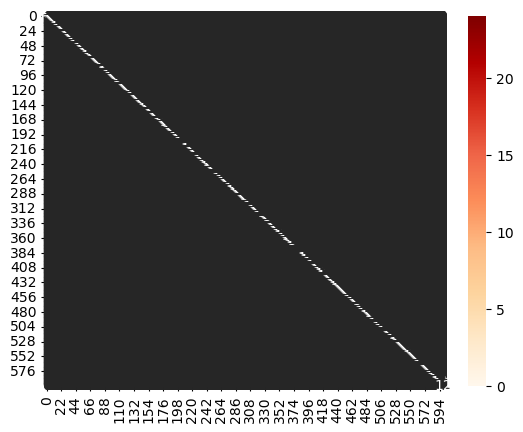

In [35]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(final_preds, true_labels)
conf
sns.heatmap(conf, annot=True,cmap="OrRd")


In [33]:
sum=0
for i in range(len(conf)):
    sum+=conf[i,i]
sum/len(test)

0.9424607961399276

In [85]:
test_o=pd.read_csv('test_with_pred.csv')
test_2=pd.concat([test_o.reset_index(drop=True),new_df['id_pred']],axis=1)
test_2

,Unnamed: 0.1,Unnamed: 0,file_path,modification,gender,hand,finger,method,id,finger_pred,hand_pred,gender_pred,id_pred
0,46088,46088,./archive/SOCOFing/Real/502__F_Left_little_fin...,0,1,1,4,0,501,4,1,0,501
1,46089,46089,./archive/SOCOFing/Real/502__F_Left_middle_fin...,0,1,1,2,0,501,1,1,0,501
2,46090,46090,./archive/SOCOFing/Real/502__F_Right_ring_fing...,0,1,0,3,0,501,1,0,0,501
3,46091,46091,./archive/SOCOFing/Real/502__F_Right_thumb_fin...,0,1,0,0,0,501,0,0,0,501
4,46092,46092,./archive/SOCOFing/Real/502__F_Left_index_fing...,0,1,1,1,0,501,2,1,0,501
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9172,55260,55260,./archive/SOCOFing/Altered/Altered-Hard/600__M...,3,0,0,3,1,599,3,0,0,599
9173,55261,55261,./archive/SOCOFing/Altered/Altered-Hard/600__M...,3,0,0,4,2,599,4,0,0,599
9174,55262,55262,./archive/SOCOFing/Altered/Altered-Hard/600__M...,3,0,0,4,1,599,4,0,0,599
9175,55263,55263,./archive/SOCOFing/Altered/Altered-Hard/600__M...,3,0,0,3,2,599,3,0,0,599


In [86]:
#test_2.to_csv('test_with_pred.csv',index=False)